In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from sklearn.svm import SVC

## Gen data

In [12]:
SEED = 0
np.random.seed(SEED)

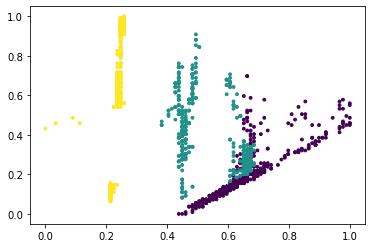

In [13]:
CLASSES = 3
NUM_OF_EACH_CLASS = 500
DIM = 9

data = np.loadtxt('../data/shuttle/shuttle.tst')
X, y = data[:, :-1], data[:, -1].astype('int')

# selection
if CLASSES == 2:
    X = np.concatenate((X[y == 1][:NUM_OF_EACH_CLASS], X[y == 4][:NUM_OF_EACH_CLASS]), axis=0)
    y = np.concatenate((np.zeros(NUM_OF_EACH_CLASS), np.ones(NUM_OF_EACH_CLASS)))
elif CLASSES == 3:
    X = np.concatenate((X[y == 1][:NUM_OF_EACH_CLASS], X[y == 4][:NUM_OF_EACH_CLASS], X[y == 5][:NUM_OF_EACH_CLASS]), axis=0)
    y = np.concatenate((np.zeros(NUM_OF_EACH_CLASS), np.ones(NUM_OF_EACH_CLASS), np.ones(NUM_OF_EACH_CLASS) * 2))

# 0-1 normalization
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

plt.scatter(X[:, 6], X[:, 7], s=8, c=y)

## Cal manifold kernel density estimation

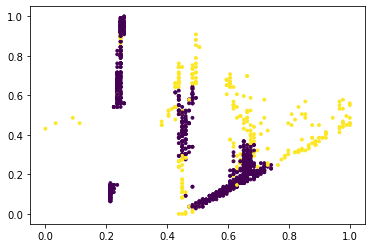

In [14]:
BANDWIDTH = 0.1

kde = KernelDensity(kernel='gaussian', bandwidth=BANDWIDTH)
kde_value = kde.fit(X).score_samples(X)
kde_argsort = np.argsort(kde_value)

is_tube = np.zeros(X.shape[0])
is_tube[kde_argsort[:int(X.shape[0] * 0.2)]] = 1
plt.scatter(X[:, 6], X[:, 7], s=8, c=is_tube)

## Experiment to Confirm Theorem

In [15]:
left_hand = np.empty(X.shape[0])
d_hat_h_o = np.empty(X.shape[0])
d_hat_h_t = np.empty(X.shape[0])
right_hand = np.empty(X.shape[0])

C_VALUE = 1
NUM_RANDOM = 100
VC_DIM = 100

clf_o = SVC(C=C_VALUE, kernel='rbf').fit(X, y)
clf_t = SVC(C=C_VALUE, kernel='rbf')
clfs_random = [
    SVC(C=C_VALUE, kernel='rbf').fit(np.random.rand(CLASSES, DIM), np.array([i for i in range(CLASSES)])) for _ in range(NUM_RANDOM)
]
start = -1
for i in tqdm(range(int(X.shape[0]))):
    # when there is no enough kinds of classes
    if len(set(y[kde_argsort[:i + 1]])) < CLASSES:
        left_hand[i] = -2
        d_hat_h_t[i] = -1
        d_hat_h_o[i] = -1
        right_hand[i] = -2
        continue
    if start == -1:
        start = i
    # calculation - left hand
    y_hat_t = clf_t.fit(X[kde_argsort[:i + 1]], y[kde_argsort[:i + 1]]).predict(X)
    y_hat_o = clf_o.predict(X)
    left_hand[i] = (1 - np.mean(y_hat_t == y)) - (1 - np.mean(y_hat_o == y))
    # calculation - right hand
    d_hat_h_t[i] = -1
    d_hat_h_o[i] = -1
    for clf_random in clfs_random:
        y_hat_random = clf_random.predict(X)
        d_hat_h_t[i] = max(d_hat_h_t[i], np.abs((1 - np.mean(y_hat_random == y_hat_t)) - 
            (1 - np.mean(y_hat_random[kde_argsort[:i + 1]] == y_hat_t[kde_argsort[:i + 1]]))))
        d_hat_h_o[i] = max(d_hat_h_o[i], np.abs((1 - np.mean(y_hat_random == y_hat_o)) - 
            (1 - np.mean(y_hat_random[kde_argsort[:i + 1]] == y_hat_o[kde_argsort[:i + 1]]))))

100%|██████████| 1500/1500 [02:53<00:00,  8.63it/s]


## Draw

Text(0.5, 0, 'Proportion of tube points')

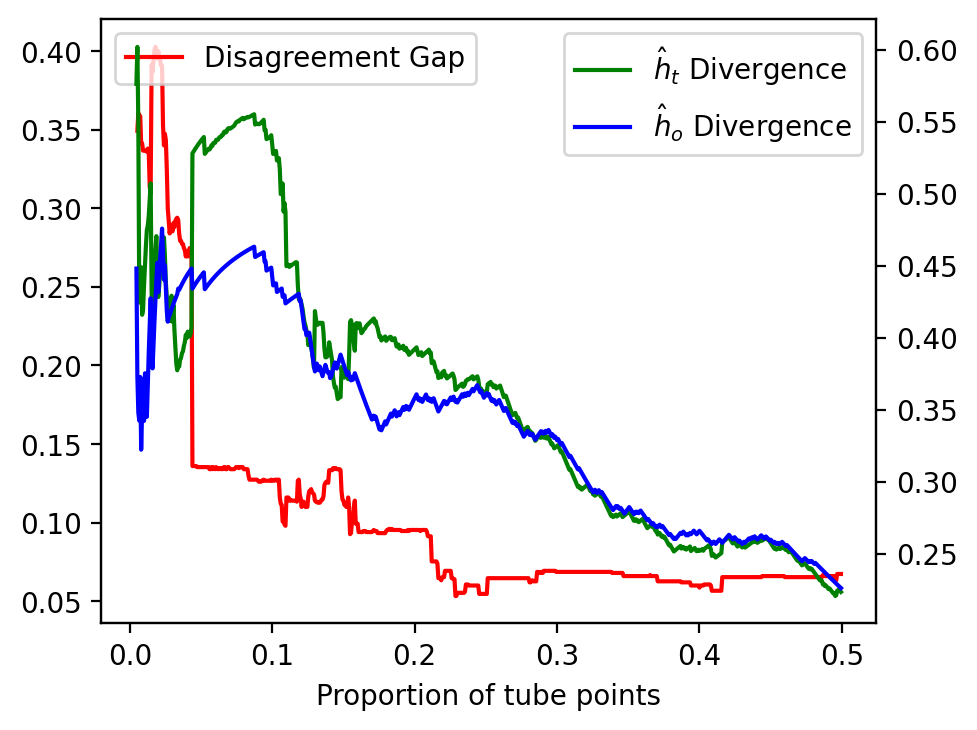

In [16]:
PROPORTION = .5

fig = plt.figure(dpi=200, figsize=(5, 4))
ax = fig.add_subplot(111)
ax.plot(np.arange(start + 1, int(X.shape[0] * PROPORTION)) / X.shape[0], left_hand[start + 1:int(X.shape[0] * PROPORTION)], '-r', label='Disagreement Gap')
ax2 = ax.twinx()
ax2.plot(np.arange(start, int(X.shape[0] * PROPORTION)) / X.shape[0], d_hat_h_t[start:int(X.shape[0] * PROPORTION)], '-g', label='$\hat h_t$ Divergence')
ax2.plot(np.arange(start, int(X.shape[0] * PROPORTION)) / X.shape[0], d_hat_h_o[start:int(X.shape[0] * PROPORTION)], '-b', label='$\hat h_o$ Divergence')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlabel('Proportion of tube points')